In [1]:
#Load relevant libraries
library(rstatix)
library(reshape)
library(tidyverse)
library(dplyr)
library(ggpubr)


Attaching package: 'rstatix'


The following object is masked from 'package:stats':

    filter


-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.2 --
v ggplot2 3.4.0     v purrr   1.0.1
v tibble  3.1.8     v dplyr   1.1.0
v tidyr   1.3.0     v stringr 1.5.0
v readr   2.1.3     v forcats 1.0.0
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x tidyr::expand() masks reshape::expand()
x dplyr::filter() masks rstatix::filter(), stats::filter()
x dplyr::lag()    masks stats::lag()
x dplyr::rename() masks reshape::rename()


In [2]:
#Load Data
DataPath<-'./Timing_for_ANOVA.txt'
Timing_data <- read.delim(DataPath, sep="\t", header=T, stringsAsFactors=F) %>% drop_na()

In [3]:
table(Timing_data$Group, Timing_data$GameNb)

          
            1  2  3  4  5  6  7  8  9 10 11 12 13 14 15
  Coupled  13 19 25 24 28 30 28 29 32 30 31 30 32 32 32
  Streamed  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9

In [4]:
##Source for "SummarySE": http://www.cookbook-r.com/Manipulating_data/Summarizing_data/
##
##
## Gives count, mean, standard deviation, standard error of the mean, and confidence interval (default 95%).
##   data: a data frame.
##   measurevar: the name of a column that contains the variable to be summariezed
##   groupvars: a vector containing names of columns that contain grouping variables
##   na.rm: a boolean that indicates whether to ignore NA's
##   conf.interval: the percent range of the confidence interval (default is 95%)
summarySE <- function(data=NULL, measurevar, groupvars=NULL, na.rm=FALSE,
                      conf.interval=.95, .drop=TRUE) {
    library(plyr)

    # New version of length which can handle NA's: if na.rm==T, don't count them
    length2 <- function (x, na.rm=FALSE) {
        if (na.rm) sum(!is.na(x))
        else       length(x)
    }

    # This does the summary. For each group's data frame, return a vector with
    # N, mean, and sd
    datac <- ddply(data, groupvars, .drop=.drop,
      .fun = function(xx, col) {
        c(N    = length2(xx[[col]], na.rm=na.rm),
          mean = mean   (xx[[col]], na.rm=na.rm),
          sd   = sd     (xx[[col]], na.rm=na.rm)
        )
      },
      measurevar
    )

    # Rename the "mean" column    
    datac <- rename(datac, c("mean" = measurevar))

    datac$se <- datac$sd / sqrt(datac$N)  # Calculate standard error of the mean

    # Confidence interval multiplier for standard error
    # Calculate t-statistic for confidence interval: 
    # e.g., if conf.interval is .95, use .975 (above/below), and use df=N-1
    ciMult <- qt(conf.interval/2 + .5, datac$N-1)
    datac$ci <- datac$se * ciMult

    return(datac)
}

------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: 'plyr'


The following object is masked from 'package:ggpubr':

    mutate


The following objects are masked from 'package:dplyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following object is masked from 'package:purrr':

    compact


The following objects are masked from 'package:reshape':

    rename, round_any


The following objects are masked from 'package:rstatix':

    desc, mutate




Group,N,ISI,sd,se,ci
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Coupled,415,542.4397,113.45513,5.569293,10.94762
Streamed,135,390.6647,66.53235,5.726193,11.32541


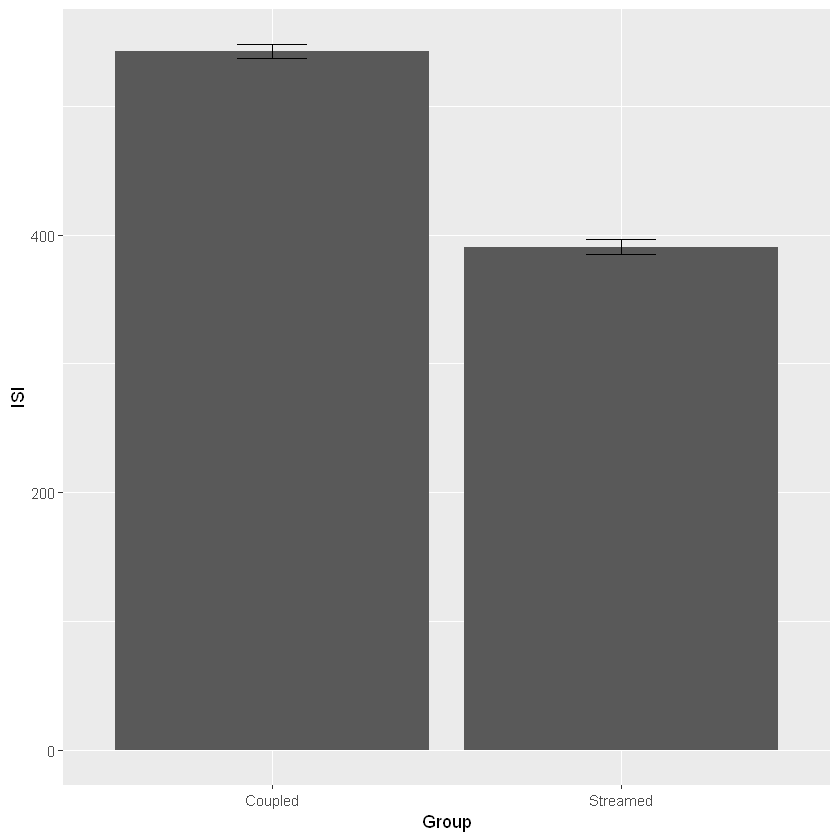

In [5]:
df1 <- summarySE(Timing_data, "ISI", c("Group"))
df1

#Bar plot
ggplot(df1, aes(x=Group, y=ISI)) + 
  geom_bar(stat = "identity") +
  geom_errorbar(aes(ymin=ISI-se, ymax=ISI+se), width=.2,
                position=position_dodge(.9))

Group,N,IRI,sd,se,ci
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Coupled,415,495.8701,37.40995,1.8363823,3.609796
Streamed,135,498.1888,11.08813,0.9543141,1.887467


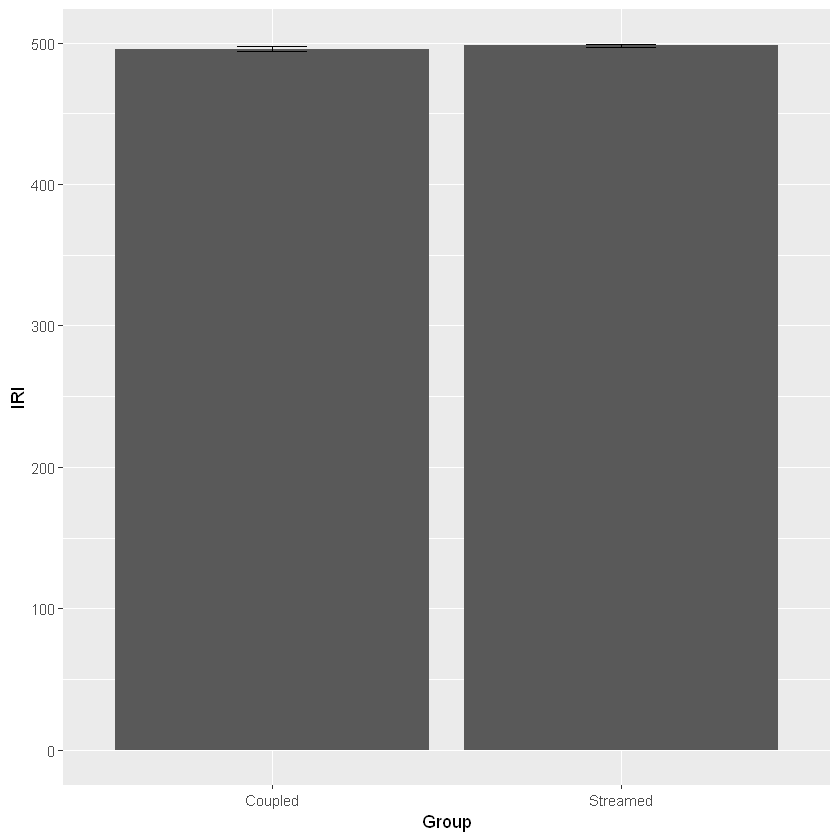

In [6]:
df2 <- summarySE(Timing_data, "IRI", c("Group"))
df2

#Bar plot
ggplot(df2, aes(x=Group, y=IRI)) + 
  geom_bar(stat = "identity") +
  geom_errorbar(aes(ymin=IRI-se, ymax=IRI+se), width=.2,
                position=position_dodge(.9))

In [8]:
#Convert to factor variables
new_data <- Timing_data %>% group_by(Subject,Group) %>% dplyr::summarize_at(c("ISI", "IRI"), mean, na.rm = TRUE)
head(new_data,10)

Subject,Group,ISI,IRI
<chr>,<chr>,<dbl>,<dbl>
A11LNK1U3DT08V,Coupled,481.8472,499.1412
A122LRCSBAD6DC,Streamed,460.6625,499.3466
A13B8594JIUFDF,Coupled,497.5995,496.8054
A13G6IRFQBEE8K,Streamed,319.0227,492.6920
A13YOOKZFZJJ10,Coupled,521.2245,506.1553
A19X8IA9EKC3XH,Streamed,373.4875,502.4523
A1DHJE69R494AH,Coupled,517.5645,492.1175
A1EP3XESXAG0EP,Coupled,487.8959,496.4038
A1FG2G0J8M9Q0N,Coupled,676.5912,486.1787


In [9]:
#Prepare ISI table
nb_rows<-nrow(new_data)
nb_rows
ISI_vec <- rep('ISI', nb_rows) 
anova_isi <- new_data[c('Subject','Group')]
#ISI_vec
anova_isi$Timing <- ISI_vec
anova_isi$Value <- new_data$ISI
head(anova_isi,10)

[1] 41

Subject,Group,Timing,Value
<chr>,<chr>,<chr>,<dbl>
A11LNK1U3DT08V,Coupled,ISI,481.8472
A122LRCSBAD6DC,Streamed,ISI,460.6625
A13B8594JIUFDF,Coupled,ISI,497.5995
A13G6IRFQBEE8K,Streamed,ISI,319.0227
A13YOOKZFZJJ10,Coupled,ISI,521.2245
A19X8IA9EKC3XH,Streamed,ISI,373.4875
A1DHJE69R494AH,Coupled,ISI,517.5645
A1EP3XESXAG0EP,Coupled,ISI,487.8959
A1FG2G0J8M9Q0N,Coupled,ISI,676.5912


In [10]:
#Prepare IRI table
nb_rows<-nrow(new_data)
nb_rows
IRI_vec <- rep('IRI', nb_rows) 
anova_iri <- new_data[c('Subject','Group')]
#IRI_vec
anova_iri$Timing <- IRI_vec
anova_iri$Value <- new_data$IRI
head(anova_iri,10)

[1] 41

Subject,Group,Timing,Value
<chr>,<chr>,<chr>,<dbl>
A11LNK1U3DT08V,Coupled,IRI,499.1412
A122LRCSBAD6DC,Streamed,IRI,499.3466
A13B8594JIUFDF,Coupled,IRI,496.8054
A13G6IRFQBEE8K,Streamed,IRI,492.6920
A13YOOKZFZJJ10,Coupled,IRI,506.1553
A19X8IA9EKC3XH,Streamed,IRI,502.4523
A1DHJE69R494AH,Coupled,IRI,492.1175
A1EP3XESXAG0EP,Coupled,IRI,496.4038
A1FG2G0J8M9Q0N,Coupled,IRI,486.1787


In [11]:
#concatenate two tables
anova_data = rbind(anova_isi,anova_iri)
nb_rows2 <- nrow(anova_data)
nb_rows2
tail(anova_data,10)

[1] 82

Subject,Group,Timing,Value
<chr>,<chr>,<chr>,<dbl>
ACGHHDT7RY1AH,Streamed,IRI,502.7714
AFM65NU0UXIGP,Streamed,IRI,492.1771
AJZYNIL3ITOK0,Coupled,IRI,497.9586
AQXRHIMQ7UK7O,Coupled,IRI,504.2036
ASZBND3G5UYJG,Coupled,IRI,482.9085
AUPXYEKITX8UT,Coupled,IRI,482.8674
AXMPSUNKUBEIL,Coupled,IRI,516.7413
AY4PZPXHSRCP5,Coupled,IRI,501.2491
AY5OS6NZWVX22,Coupled,IRI,503.8019


In [12]:
#need factors for ANOVA
anova_df <- anova_data %>% 
  convert_as_factor(Subject,Group,Timing)
head(anova_df, 10)
#anova_df$Timing

Subject,Group,Timing,Value
<fct>,<fct>,<fct>,<dbl>
A11LNK1U3DT08V,Coupled,ISI,481.8472
A122LRCSBAD6DC,Streamed,ISI,460.6625
A13B8594JIUFDF,Coupled,ISI,497.5995
A13G6IRFQBEE8K,Streamed,ISI,319.0227
A13YOOKZFZJJ10,Coupled,ISI,521.2245
A19X8IA9EKC3XH,Streamed,ISI,373.4875
A1DHJE69R494AH,Coupled,ISI,517.5645
A1EP3XESXAG0EP,Coupled,ISI,487.8959
A1FG2G0J8M9Q0N,Coupled,ISI,676.5912


In [13]:
####### mixed ANOVA ####### Use this for paper
anova_df$Value <- as.numeric(anova_df$Value)
anova_df <- ungroup(anova_df)
ws_anova <- anova_test(
  data = anova_df, dv = Value, wid = Subject,
  within = c(Timing),between=c(Group)
)
get_anova_table(ws_anova)

,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,Group,1,39,25.449,1.09e-05,*,0.247
2,Timing,1,39,3.477,7.00e-02,,0.042
3,Group:Timing,1,39,27.340,6.07e-06,*,0.259


In [14]:
Streamed_df = new_data %>% filter(Group=='Streamed')
Coupled_df = new_data %>% filter(Group=='Coupled')
print("Streamed & Coupled ISI")
mean(Streamed_df$ISI)
mean(Coupled_df$ISI)
print("Streamed & Coupled IRI")
mean(Streamed_df$IRI)
mean(Coupled_df$IRI)

[1] "Streamed & Coupled ISI"


[1] 390.6647

[1] 546.7453

[1] "Streamed & Coupled IRI"


[1] 498.1888

[1] 495.7527

In [15]:
Streamed_df = anova_df %>% filter(Group=='Streamed')
Coupled_df = anova_df %>% filter(Group=='Coupled')
print("Streamed & Coupled IPI")
mean(Streamed_df$Value)
mean(Coupled_df$Value)

[1] "Streamed & Coupled IPI"


[1] 444.4267

[1] 521.249

In [20]:
#Post-hoc tests
times <- ddply(anova_df, c("Group","Timing","Subject"), summarize, Value=mean(Value))
#head(times,5)
pwc <- times %>%
  pairwise_t_test(
    Value ~ Group, paired = FALSE,
    p.adjust.method = "bonferroni"
  )
pwc

,.y.,group1,group2,n1,n2,p,p.signif,p.adj,p.adj.signif
,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<dbl>,<chr>
1,Value,Coupled,Streamed,64,18,3.63e-05,****,3.63e-05,****


In [21]:
#concatenate two tables
interac_data = anova_data
nb_rows2 <- nrow(interac_data)
nb_rows2
Interac <- print(paste(interac_data$Group,interac_data$Timing))
interac_data$Level <- Interac
tail(interac_data,10)

[1] 82

 [1] "Coupled ISI"  "Streamed ISI" "Coupled ISI"  "Streamed ISI" "Coupled ISI" 
 [6] "Streamed ISI" "Coupled ISI"  "Coupled ISI"  "Coupled ISI"  "Streamed ISI"
[11] "Coupled ISI"  "Streamed ISI" "Streamed ISI" "Coupled ISI"  "Coupled ISI" 
[16] "Coupled ISI"  "Coupled ISI"  "Coupled ISI"  "Coupled ISI"  "Coupled ISI" 
[21] "Coupled ISI"  "Coupled ISI"  "Coupled ISI"  "Coupled ISI"  "Coupled ISI" 
[26] "Coupled ISI"  "Coupled ISI"  "Coupled ISI"  "Coupled ISI"  "Coupled ISI" 
[31] "Streamed ISI" "Streamed ISI" "Streamed ISI" "Coupled ISI"  "Coupled ISI" 
[36] "Coupled ISI"  "Coupled ISI"  "Coupled ISI"  "Coupled ISI"  "Coupled ISI" 
[41] "Coupled ISI"  "Coupled IRI"  "Streamed IRI" "Coupled IRI"  "Streamed IRI"
[46] "Coupled IRI"  "Streamed IRI" "Coupled IRI"  "Coupled IRI"  "Coupled IRI" 
[51] "Streamed IRI" "Coupled IRI"  "Streamed IRI" "Streamed IRI" "Coupled IRI" 
[56] "Coupled IRI"  "Coupled IRI"  "Coupled IRI"  "Coupled IRI"  "Coupled IRI" 
[61] "Coupled IRI"  "Coupled IRI"  "Coup

Subject,Group,Timing,Value,Level
<chr>,<chr>,<chr>,<dbl>,<chr>
ACGHHDT7RY1AH,Streamed,IRI,502.7714,Streamed IRI
AFM65NU0UXIGP,Streamed,IRI,492.1771,Streamed IRI
AJZYNIL3ITOK0,Coupled,IRI,497.9586,Coupled IRI
AQXRHIMQ7UK7O,Coupled,IRI,504.2036,Coupled IRI
ASZBND3G5UYJG,Coupled,IRI,482.9085,Coupled IRI
AUPXYEKITX8UT,Coupled,IRI,482.8674,Coupled IRI
AXMPSUNKUBEIL,Coupled,IRI,516.7413,Coupled IRI
AY4PZPXHSRCP5,Coupled,IRI,501.2491,Coupled IRI
AY5OS6NZWVX22,Coupled,IRI,503.8019,Coupled IRI


In [22]:
#Post-hoc tests - PAIRED
times2 <- ddply(interac_data, c("Level","Subject"), summarize, Value=mean(Value))
#head(times2,5)
pwc2 <- times2 %>%
  pairwise_t_test(
    Value ~ Level, paired = FALSE,
    p.adjust.method = "bonferroni"
  )
pwc2

,.y.,group1,group2,n1,n2,p,p.signif,p.adj,p.adj.signif
,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<dbl>,<chr>
1,Value,Coupled IRI,Coupled ISI,32,32,5.92e-04,***,3.55e-03,**
2,Value,Coupled IRI,Streamed IRI,32,9,9.10e-01,ns,1.00e+00,ns
3,Value,Coupled ISI,Streamed IRI,32,9,2.66e-02,*,1.60e-01,ns
4,Value,Coupled IRI,Streamed ISI,32,9,5.28e-06,****,3.17e-05,****
5,Value,Coupled ISI,Streamed ISI,32,9,2.47e-10,****,1.48e-09,****
6,Value,Streamed IRI,Streamed ISI,9,9,1.40e-04,***,8.42e-04,***


In [23]:
model <- aov(Value~Level, data=interac_data)
summary(model)

            Df Sum Sq Mean Sq F value   Pr(>F)    
Level        3 176541   58847   18.15 5.01e-09 ***
Residuals   78 252951    3243                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

In [24]:
TukeyHSD(model, conf.level=.95)

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Value ~ Level, data = interac_data)

$Level
                                 diff        lwr        upr     p adj
Coupled ISI-Coupled IRI     50.992538   13.61694  88.368141 0.0032541
Streamed IRI-Coupled IRI     2.436061  -53.97235  58.844473 0.9994742
Streamed ISI-Coupled IRI  -105.088074 -161.49649 -48.679661 0.0000309
Streamed IRI-Coupled ISI   -48.556477 -104.96489   7.851935 0.1165326
Streamed ISI-Coupled ISI  -156.080612 -212.48902 -99.672200 0.0000000
Streamed ISI-Streamed IRI -107.524135 -178.00025 -37.048023 0.0007955
